# all flight partners PTE email to PTE+AOP offers conversion prediction

In [ ]:
!pip install ipython-sql

In [ ]:
#!pip install -U numpy

In [ ]:
#!python --version

In [ ]:
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [6]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = '../../redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [7]:
query="""
SELECT * FROM ml_prep.gauthier_all_flights_pte_aop_email_to_offer where email_sent_date >= '2019-10-20 00:00:00' AND email_sent_date < '2019-11-07 00:00:00'  ;
"""
df = pd.read_sql_query(query, con)
df.head(10)


email_sent_date_in_segment_1_origin_tz     pnr  partner_id point_of_sale  \
0                2019-11-05 19:51:48.374  1HX9VE          29            RS   
1                2019-11-06 09:59:43.790  1PJWOW          12            DK   
2                2019-11-02 19:51:03.753  223HI6           9            US   
3                2019-10-20 15:54:26.771  22455B           9            IE   
4                2019-10-20 13:15:57.284  224PVF           9            US   
5                2019-10-20 19:18:28.333  224WQN           9            IE   
6                2019-11-01 11:04:53.300  225LY2           9            US   
7                2019-11-03 10:09:08.068  225Y6J           9            US   
8                2019-10-21 11:22:21.174  226FG2           9            IE   
9                2019-11-03 16:48:58.451  226UDS           9            IE   

  language  loyalty_level  passenger_count         email_sent_date  \
0       en              0                3 2019-11-05 19:51:48.374   
1       is              0                1 2019-11-06 09:59:43.790   
2       EN              0                3 2019-11-02 23:51:03.753   
3       EN              0                2 2019-10-20 14:54:26.771   
4       EN              0                1 2019-10-20 17:15:57.284   
5       DE              0                4 2019-10-20 18:18:28.333   
6       EN              0                2 2019-11-01 16:04:53.300   
7       EN              0                1 2019-11-03 16:09:08.068   
8       EN              0                1 2019-10-21 10:22:21.174   
9       EN              0                3 2019-11-03 16:48:58.451   

  segment_1_origination segment_1_destination  ...  \
0                   LIS                   LHR  ...   
1                   KEF                   MUC  ...   
2                   IAD                   DUB  ...   
3                   DUB                   ORD  ...   
4                   JFK                   DUB  ...   
5                   DUB                   EWR  ...   
6                   ORD                   DUB  ...   
7                   MSP                   DUB  ...   
8                   DUB                   YYZ  ...   
9                   DUB                   YYZ  ...   

  segment_4_booked_fare_class segment_4_upgrade_cabin  \
0                                                       
1                                                       
2                                                       
3                                                       
4                                                       
5                                                       
6                                                       
7                                                       
8                                                       
9                                                       

   segment_4_flight_number segment_4_carrier_code  \
0                      NaN                          
1                      NaN                          
2                      NaN                          
3                      NaN                          
4                      NaN                          
5                      NaN                          
6                      NaN                          
7                      NaN                          
8                      NaN                          
9                      NaN                          

  segment_4_departure_local_date_time total_amount_itinerary_usd  \
0                                                            NaN   
1                                                            NaN   
2                                                            NaN   
3                                                            NaN   
4                                                            NaN   
5                                                            NaN   
6                                                            NaN   
7                    

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707510 entries, 0 to 1707509
Data columns (total 41 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   email_sent_date_in_segment_1_origin_tz  datetime64[ns]
 1   pnr                                     object        
 2   partner_id                              int64         
 3   point_of_sale                           object        
 4   language                                object        
 5   loyalty_level                           int64         
 6   passenger_count                         int64         
 7   email_sent_date                         datetime64[ns]
 8   segment_1_origination                   object        
 9   segment_1_destination                   object        
 10  segment_1_booked_fare_class             object        
 11  segment_1_upgrade_cabin                 object        
 12  segment_1_flight_number                 in

# Feature Engineering

In [9]:
# compute some time-related features
# this takes some time

df['email_sent_date'] = df['email_sent_date_in_segment_1_origin_tz']

# email sent time
df['email_sent_day_of_week']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.dayofweek)
df['email_sent_hour']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.hour)
df['email_sent_month']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.month)
df['email_sent_year']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.year)
df["email_sent_days_before_departure"] =(pd.to_datetime(df["segment_1_departure_local_date_time"])-pd.to_datetime(df["email_sent_date"]).dt.tz_localize(None)).apply(lambda x: x.days)


In [10]:
# segment 1 
df['segment_1_departure_hour'] = pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_1_departure_day_of_week']= pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_1_departure_month']= pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_1_origin_destination'] = df['segment_1_origination']+ df['segment_1_destination']

# segment 2
df['segment_2_departure_hour'] = pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_2_departure_day_of_week']= pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_2_departure_month']= pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_2_origin_destination'] = df['segment_2_origination']+ df['segment_2_destination']

# segment 3
df['segment_3_departure_hour'] = pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_3_departure_day_of_week']= pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_3_departure_month']= pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_3_origin_destination'] = df['segment_3_origination']+ df['segment_3_destination']

# segment 4
df['segment_4_departure_hour'] = pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_4_departure_day_of_week']= pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_4_departure_month']= pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_4_origin_destination'] = df['segment_4_origination']+ df['segment_4_destination']

df['passenger_count'] = df['passenger_count'].fillna(0).astype(int)


In [11]:
df[:3]

email_sent_date_in_segment_1_origin_tz     pnr  partner_id point_of_sale  \
0                2019-11-05 19:51:48.374  1HX9VE          29            RS   
1                2019-11-06 09:59:43.790  1PJWOW          12            DK   
2                2019-11-02 19:51:03.753  223HI6           9            US   

  language  loyalty_level  passenger_count         email_sent_date  \
0       en              0                3 2019-11-05 19:51:48.374   
1       is              0                1 2019-11-06 09:59:43.790   
2       EN              0                3 2019-11-02 19:51:03.753   

  segment_1_origination segment_1_destination  ... segment_2_departure_month  \
0                   LIS                   LHR  ...                         0   
1                   KEF                   MUC  ...                         0   
2                   IAD                   DUB  ...                         7   

  segment_2_origin_destination  segment_3_departure_hour  \
0                                                      0   
1                                                      0   
2                       DUBIAD                         0   

  segment_3_departure_day_of_week segment_3_departure_month  \
0                               0                         0   
1                               0                         0   
2                               0                         0   

  segment_3_origin_destination segment_4_departure_hour  \
0                                                     0   
1                                                     0   
2                                                     0   

  segment_4_departure_day_of_week segment_4_departure_month  \
0                               0                         0   
1                               0                         0   
2                               0                         0   

   segment_4_origin_destination  
0                                
1                                
2                                

[3 rows x 62 columns]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707510 entries, 0 to 1707509
Data columns (total 62 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   email_sent_date_in_segment_1_origin_tz  datetime64[ns]
 1   pnr                                     object        
 2   partner_id                              int64         
 3   point_of_sale                           object        
 4   language                                object        
 5   loyalty_level                           int64         
 6   passenger_count                         int64         
 7   email_sent_date                         datetime64[ns]
 8   segment_1_origination                   object        
 9   segment_1_destination                   object        
 10  segment_1_booked_fare_class             object        
 11  segment_1_upgrade_cabin                 object        
 12  segment_1_flight_number                 in

# Feature Encoding

In [13]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [14]:
# label-encode categories
# there is no channel source since it's always PTE.
columns = ['language','point_of_sale'] + \
['segment_1_origination','segment_1_destination','segment_1_origin_destination','segment_1_booked_fare_class','segment_1_upgrade_cabin']+ \
['segment_2_origination','segment_2_destination','segment_2_origin_destination','segment_2_booked_fare_class','segment_2_upgrade_cabin'] + \
['segment_3_origination','segment_3_destination','segment_3_origin_destination','segment_3_booked_fare_class','segment_3_upgrade_cabin'] + \
['segment_4_origination','segment_4_destination','segment_4_origin_destination','segment_4_booked_fare_class','segment_4_upgrade_cabin'] 

df= label_encode_categorical(df,columns)


label encoding language ...
label encoding point_of_sale ...
label encoding segment_1_origination ...
label encoding segment_1_destination ...
label encoding segment_1_origin_destination ...
label encoding segment_1_booked_fare_class ...
label encoding segment_1_upgrade_cabin ...
label encoding segment_2_origination ...
label encoding segment_2_destination ...
label encoding segment_2_origin_destination ...
label encoding segment_2_booked_fare_class ...
label encoding segment_2_upgrade_cabin ...
label encoding segment_3_origination ...
label encoding segment_3_destination ...
label encoding segment_3_origin_destination ...
label encoding segment_3_booked_fare_class ...
label encoding segment_3_upgrade_cabin ...
label encoding segment_4_origination ...
label encoding segment_4_destination ...
label encoding segment_4_origin_destination ...
label encoding segment_4_booked_fare_class ...
label encoding segment_4_upgrade_cabin ...


In [15]:
columns_for_training= [    
                        # segment 1
                        'segment_1_origination_encoded',
                        'segment_1_destination_encoded',
                        'segment_1_origin_destination_encoded',
                        'segment_1_booked_fare_class_encoded',
                        'segment_1_upgrade_cabin_encoded',
    
                         # segment 2
                        'segment_2_origination_encoded',
                        'segment_2_destination_encoded',
                        'segment_2_origin_destination_encoded',
                        'segment_2_booked_fare_class_encoded',
                        'segment_2_upgrade_cabin_encoded',

                         # segment 3
                        'segment_3_origination_encoded',
                        'segment_3_destination_encoded',
                        'segment_3_origin_destination_encoded',
                        'segment_3_booked_fare_class_encoded',
                        'segment_3_upgrade_cabin_encoded',

                         # segment 4
                        'segment_4_origination_encoded',
                        'segment_4_destination_encoded',
                        'segment_4_origin_destination_encoded',
                        'segment_4_booked_fare_class_encoded',
                        'segment_4_upgrade_cabin_encoded',
    
                        # email
                        'email_sent_day_of_week',
                        'email_sent_hour',
                        'email_sent_month',
                        'email_sent_year',
                        'email_sent_days_before_departure',
    
                        # partner id
                        'partner_id',
    
                       # the rest
                       'language_encoded',
                       'passenger_count',
                       'point_of_sale_encoded',

                       # target
                        'has_offer',
                      ]

df_train = df[columns_for_training]

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707510 entries, 0 to 1707509
Data columns (total 30 columns):
 #   Column                                Dtype
---  ------                                -----
 0   segment_1_origination_encoded         int64
 1   segment_1_destination_encoded         int64
 2   segment_1_origin_destination_encoded  int64
 3   segment_1_booked_fare_class_encoded   int64
 4   segment_1_upgrade_cabin_encoded       int64
 5   segment_2_origination_encoded         int64
 6   segment_2_destination_encoded         int64
 7   segment_2_origin_destination_encoded  int64
 8   segment_2_booked_fare_class_encoded   int64
 9   segment_2_upgrade_cabin_encoded       int64
 10  segment_3_origination_encoded         int64
 11  segment_3_destination_encoded         int64
 12  segment_3_origin_destination_encoded  int64
 13  segment_3_booked_fare_class_encoded   int64
 14  segment_3_upgrade_cabin_encoded       int64
 15  segment_4_origination_encoded         int64
 16  

In [17]:
df_train.head(4)

segment_1_origination_encoded  segment_1_destination_encoded  \
0                            347                            345   
1                            293                            413   
2                            261                            172   
3                            168                            453   

   segment_1_origin_destination_encoded  segment_1_booked_fare_class_encoded  \
0                                  2597                                   34   
1                                  2221                                   34   
2                                  1924                                   36   
3                                  1345                                   18   

   segment_1_upgrade_cabin_encoded  segment_2_origination_encoded  \
0                                2                              0   
1                                7                              0   
2                                2                            173   
3                                2                            459   

   segment_2_destination_encoded  segment_2_origin_destination_encoded  \
0                              0                                     0   
1                              0                                     0   
2                            261                                  1336   
3                            170                                  3431   

   segment_2_booked_fare_class_encoded  segment_2_upgrade_cabin_encoded  ...  \
0                                    0                                0  ...   
1                                    0                                0  ...   
2                                   24                                3  ...   
3                                   19                                3  ...   

   email_sent_day_of_week  email_sent_hour  email_sent_month  email_sent_year  \
0                       1               19                11             2019   
1                       2                9                11             2019   
2                       5               19                11             2019   
3                       6               15                10             2019   

   email_sent_days_before_departure  partner_id  language_encoded  \
0                                25          29                18   
1                               131          12                59   
2                               235           9                 1   
3                                60           9                 1   

   passenger_count  point_of_sale_encoded  has_offer  
0                3                    130      False  
1                1                     39      False  
2                3                    152      False  
3                2                     67      False  

[4 rows x 30 columns]

In [18]:
# we could use month to split train/test data
#pd.DataFrame.hist(df_train,column='email_sent_year')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94cda70518>]],
      dtype=object)

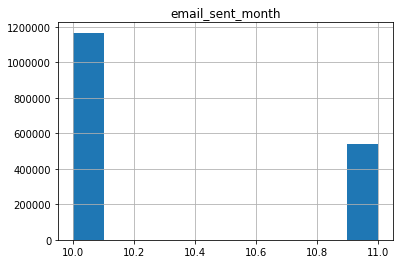

In [19]:
# we could use month to split train/test data
pd.DataFrame.hist(df_train,column='email_sent_month')

# Model Training & Evaluation

In [20]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, title=None):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title is not None:
        plt.title(title)
    plt.show()
        

In [21]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False, by_partner=False, sim=False):
    # X-validation
    import warnings
    from sklearn.exceptions import UndefinedMetricWarning
    warnings.filterwarnings('ignore', category=UndefinedMetricWarning) 
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest = RandomForestClassifier(n_estimators=100)
    X = df_to_train.drop("has_offer", axis=1)
    y = df_to_train["has_offer"]

    
    if split_on_time:
        X_train = X[X["email_sent_month"] == 10 ].drop("email_sent_month", axis=1)
        y_train = y[X["email_sent_month"] == 10]
        X_test = X[X["email_sent_month"] == 11].drop("email_sent_month", axis=1)
        y_test = y[X["email_sent_month"] == 11]
        print('split on time')
    else:
        X = X.drop("email_sent_month", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)
        print('random split')

    print('training on', str(len(X_train)), 'rows...')
    print('testing on', str(len(X_test)), 'rows...')

    random_forest.fit(X_train, y_train)
    print('training is done!')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)[:,1]
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(10,7))
    plt.title('ROC')
    plt.plot([0, 1], [0,1], 'k--')
    plt.plot(fpr, tpr,marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    auc = metrics.auc(fpr, tpr)

    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_test_proba)
    plt.figure(figsize=(10,7))
    plt.title('Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # proportion of positive examples
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.plot(recalls, precisions, marker='.')    

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    print('precision', precision[1])
    print('recall', recall[1])
    print('f1', f1[1])
    print('support', support[1])

    cm = metrics.confusion_matrix(y_test, y_test_predict)
    print_confusion_matrix(cm, ['no bid','bid'])
    print('roc auc', auc)
    
    features = X_train.columns
    importances = random_forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the impurity-based feature importances of the forest
    plt.figure(figsize=(16,9))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
    plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    for feature,importance in zip(features[indices],importances[indices]):
        print(feature+','+str(importance))
    plt.show()

    if sim:
        print('Running simulation on test set')
        total_email_sent = len(y_test)
        print(total_email_sent, 'email sent')
        print(len(y_test[y_test==1]), 'actual number of offers')
        ratio = len(y_test[y_test==1]) / total_email_sent
        print('conversion ratio',ratio)
        threshold=0.5
        predicted_positive = len(y_test_proba[y_test_proba > threshold])
        print('predicted_positive',predicted_positive,'with threshold',threshold)
        total_current_proba = y_test_proba.sum()
        total_max_proba = 0
        best_sent_hours_for_all=[]
        original_sent_hours_for_all=[]

        all_dfs=[]
        for email_sent_hour in range(0,24):
            #min_index = email_sent_hour * total_email_sent
            #max_index = (email_sent_hour +1) * total_email_sent
            #print('email_sent_hour',email_sent_hour,'min_index',min_index,'max_index',max_index)
            #X_test_repeated.iloc[min_index:max_index]['email_sent_date'] = email_sent_hour
            df_for_hour = X_test.copy()
            df_for_hour['email_sent_hour'] = email_sent_hour
            all_dfs.append(df_for_hour)
            
        X_test_repeated=pd.concat(all_dfs,ignore_index=True)
        print('size of new test set',X_test_repeated.shape[0])
        proba_repeated = random_forest.predict_proba(X_test_repeated)[:,1]
        
        mod = int(X_test.shape[0] / 20)
        
        best_proba_by_partner = {}
        
        for index in range(total_email_sent):
            indexes = []
            for email_sent_hour in range(0,24):
                indexes.append( email_sent_hour * total_email_sent + index)
            
            probas_for_index = proba_repeated[indexes]
            original_email_sent_hour = X_test.iloc[index]['email_sent_hour']
            original_proba = y_test_proba[index]
            
            max_proba = max(probas_for_index)
            
            best_email_sent_hour = np.argmax(probas_for_index)
            
            if max_proba==original_proba:
                best_email_sent_hour=original_email_sent_hour
            
            if index % mod == 0 :
                print('Row',index,'raw_email_sent_hour',original_email_sent_hour,
                         'raw_proba',original_proba,'best_email_sent_hour',best_email_sent_hour,'best_proba',max_proba)
                #print(probas_for_index)
            
            best_sent_hours_for_all.append(best_email_sent_hour)
            original_sent_hours_for_all.append(original_email_sent_hour)
            
            new_sum_for_partner = best_proba_by_partner.get(X_test.iloc[index]['partner_id'], 0) + max_proba
            best_proba_by_partner[X_test.iloc[index]['partner_id']] = new_sum_for_partner
            
            total_max_proba = total_max_proba + max_proba
            
        print('total_current_proba',total_current_proba)
        print('total_max_proba',total_max_proba)

        # if our model was perfect, it would increase ...
        
        plt.hist(original_sent_hours_for_all)
        plt.title('Original sent hour')
        plt.show()

        
        plt.hist(best_sent_hours_for_all)
        plt.title('Optimized sent hour')
        plt.show()
        
        partner_ids = sorted(X_test['partner_id'].unique())
        print('found ', str(len(partner_ids)),'partners in the test set')
        for partner_id in partner_ids:
            indexes_for_partner = X_test['partner_id'] == partner_id
            original_proba_for_partner = y_test_proba[indexes_for_partner].sum()
            print('partner_id',partner_id,'original_proba_for_partner',original_proba_for_partner,'optimized proba',best_proba_by_partner[partner_id])
        
    if by_partner:
        print('Analysis by partner...')
        partner_ids = sorted(X_test['partner_id'].unique())
        print(partner_ids)
        rocs = []
        f1s = []

        print('found ', str(len(partner_ids)),'partners in the test set')
        for partner_id in partner_ids:
            indexes_for_partner = X_test['partner_id'] == partner_id
            y_test_for_partner = y_test[indexes_for_partner] 
            y_test_proba_for_partner = y_test_proba[indexes_for_partner]
            y_test_predict_for_partner = y_test_predict[indexes_for_partner]
            
            y_for_partner = y[X['partner_id'] == partner_id]
            
            fpr, tpr, _ = metrics.roc_curve(y_test_for_partner, y_test_proba_for_partner)
            auc = metrics.auc(fpr, tpr)
            print('#### Partner',str(partner_id)+' ('+str(len(y_test_proba_for_partner)),'rows in test set) #### ')
            print('roc auc',auc)
            rocs.append(auc)
            try:
                precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test_for_partner,y_test_predict_for_partner)
                print('precision', precision[1])
                print('recall', recall[1])
                print('f1', f1[1])
                print('support', support[1])
                the_f1 = f1[1]
                plt.figure(figsize=(10,7))
                plt.title('Precision-Recall for partner '+ str(partner_id))
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                precisions, recalls, thresholds = metrics.precision_recall_curve(y_test_for_partner, y_test_proba_for_partner)
                # proportion of positive examples
                no_skill = len(y_for_partner[y_for_partner==1]) / len(y_for_partner)
                plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
                plt.plot(recalls, precisions, marker='.')    
                plt.show()
                cm = metrics.confusion_matrix(y_test_for_partner, y_test_predict_for_partner)
                print_confusion_matrix(cm, ['no bid','bid'], title='partner id ' + str(partner_id))
            except:
                the_f1 = 0
            f1s.append(the_f1)
        plt.figure(figsize=(16,9))
        plt.title('ROC by partner')
        plt.bar([str(i) for i in partner_ids], rocs, color='b', align='center')   
        plt.xticks(rotation=90)
        plt.show()
        
        plt.figure(figsize=(16,9))
        plt.title('F1 by partner')
        plt.bar([str(i) for i in partner_ids], f1s, color='b', align='center')   
        plt.xticks(rotation=90)
        plt.show()
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")

        print(train_sizes)
        print(train_scores)
        print(test_scores)


split on time
training on 341183 rows...
testing on 158817 rows...
training is done!
precision 0.05327868852459016
recall 0.005749668288367979
f1 0.010379241516966068
support 2261


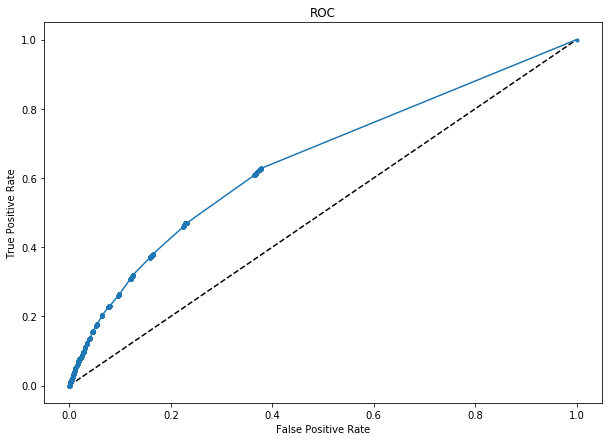

roc auc 0.6512409998955965
email_sent_day_of_week,0.13957284839072626
segment_1_booked_fare_class_encoded,0.1285219622447008
segment_1_origin_destination_encoded,0.08246350587980077
email_sent_days_before_departure,0.0798072885926923
email_sent_hour,0.07930551609197899
segment_2_booked_fare_class_encoded,0.0783789245042051
segment_1_destination_encoded,0.056340948192206294
passenger_count,0.05512880323438975
segment_2_origin_destination_encoded,0.047932122644450244
segment_1_origination_encoded,0.046862520805631074
segment_2_destination_encoded,0.033079056879619886
point_of_sale_encoded,0.031791515078614704
segment_2_origination_encoded,0.027304592398563227
partner_id,0.01869734741536034
language_encoded,0.015678544020240107
segment_3_origin_destination_encoded,0.010984464148531468
segment_3_booked_fare_class_encoded,0.009524041258944562
segment_3_origination_encoded,0.009145116852626395
segment_2_upgrade_cabin_encoded,0.00900407988725913
segment_1_upgrade_cabin_encoded,0.0082976920310

Running simulation on test set
158817 email sent
2261 actual number of offers
conversion ratio 0.014236511204719898
predicted_positive 244 with threshold 0.5
size of new test set 3811608
Row 0 raw_email_sent_hour 17 raw_proba 0.01 best_email_sent_hour 0 best_proba 0.12
Row 7940 raw_email_sent_hour 10 raw_proba 0.0 best_email_sent_hour 0 best_proba 0.02
Row 15880 raw_email_sent_hour 10 raw_proba 0.0 best_email_sent_hour 0 best_proba 0.06
Row 23820 raw_email_sent_hour 13 raw_proba 0.01 best_email_sent_hour 11 best_proba 0.1
Row 31760 raw_email_sent_hour 14 raw_proba 0.04 best_email_sent_hour 0 best_proba 0.1
Row 39700 raw_email_sent_hour 19 raw_proba 0.07 best_email_sent_hour 14 best_proba 0.09
Row 47640 raw_email_sent_hour 10 raw_proba 0.0 best_email_sent_hour 11 best_proba 0.09
Row 55580 raw_email_sent_hour 10 raw_proba 0.03 best_email_sent_hour 2 best_proba 0.2
Row 63520 raw_email_sent_hour 9 raw_proba 0.01 best_email_sent_hour 0 best_proba 0.05
Row 71460 raw_email_sent_hour 10 raw_pr

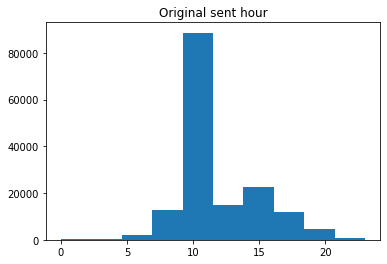

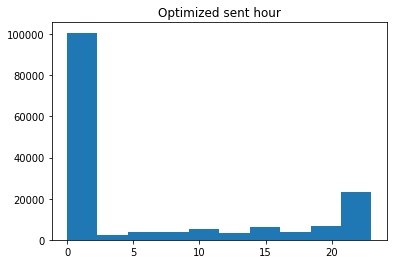

found  48 partners in the test set
partner_id 1 original_proba_for_partner 48.447880952380956 optimized proba 135.88486904761902
partner_id 4 original_proba_for_partner 33.01461204481793 optimized proba 241.03351190476295
partner_id 8 original_proba_for_partner 34.17097835497836 optimized proba 133.57228787878796
partner_id 9 original_proba_for_partner 38.22319047619048 optimized proba 104.34883333333337
partner_id 11 original_proba_for_partner 84.67436507936509 optimized proba 283.6853174603191
partner_id 12 original_proba_for_partner 51.13152380952381 optimized proba 170.50414285714376
partner_id 13 original_proba_for_partner 99.50910558885559 optimized proba 293.09865212565376
partner_id 18 original_proba_for_partner 8.992222222222223 optimized proba 56.84307936507949
partner_id 20 original_proba_for_partner 0.2 optimized proba 0.28
partner_id 23 original_proba_for_partner 3.4760238095238094 optimized proba 19.951166666666648
partner_id 24 original_proba_for_partner 7.02933333333333

In [22]:
train_and_evaluate(df_train,plot_learning_curves=False,limit=500_000, split_on_time=True, sim=True)

In [ ]:
train_and_evaluate(df_train,plot_learning_curves=False,limit=None, split_on_time=True, by_partner=True)